In [217]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)  

# Data Transformation

### Reading and Clean the Dataset

In [218]:
# Load dataset and convert 'Date' column to datetime format
df = pd.read_csv('../data/DATASET_final_untransformed_uncleaned.csv', sep=";")
df["Date"] = pd.to_datetime(df["Date"])

# Keep only the data from June 1, 2018, onwards, as the global radiation dataset starts from this date (reported by Celine)
df = df[df["Date"] >= '2018-06-01']

# Set 'Date' as the index for time-based operations
df.set_index("Date", inplace=True)

# Define valid value ranges for data cleaning
valid_ranges = {
    'Air_Temperature': (-90, 60),
    'Relative_Humidity': (0, 100),
    'Visibility': (0, 10),
    'Air_Pressure_at_Station_Height': (870, 1085),
    'Cloud_Cover': (0, 8),
    'Daily_Precipitation_Height': (0, np.inf),
    'Snow_Height_Daily_Value': (0, np.inf),
    'Global_Radiation': (0.1, np.inf),
    'Vapor_Pressure': (0, 70),
    'Dew_Point_Temperature': (-80, 30),
    'Wind_Direction': (0, 31),
    'Wind_Strength': (0, 12),
}

def clean_column(x, col_name):
    """Replace values outside the valid range with NaN."""
    min_val, max_val = valid_ranges.get(col_name, (None, None))
    return x.where((x >= min_val) & (x <= max_val), np.nan) if min_val is not None else x

# Apply cleaning function to all columns
for col in df.columns:
    df[col] = clean_column(df[col], col)

### Imputing Missing Values

In [219]:
from sklearn.experimental import enable_iterative_imputer  # This is necessary to enable IterativeImputer
from sklearn.impute import IterativeImputer

# Initialize IterativeImputer (MICE method)
imputer = IterativeImputer(max_iter=10, random_state=0)

# Impute missing values and convert back to DataFrame with original columns
df_imputed = pd.DataFrame(imputer.fit_transform(df), 
                                               columns=df.columns)

# Clip negative values to 0 for all columns after imputation, except 'Dew_Point_Temperature' and 'Air_Temperature', 
# as these columns can validly contain negative values (e.g., for temperatures below freezing).
columns_to_clip = df_imputed.columns.difference(['Dew_Point_Temperature', 'Air_Temperature'])

# Apply clipping for all columns except the ones in the exclusion list
df_imputed[columns_to_clip] = df_imputed[columns_to_clip].clip(lower=0)

# Restore the original index and update the original dataframe
df_imputed.index = df.index

# Exploratory Data Analysis

### Data Visualization

In [220]:
# # Set up the figure and axes
# num_columns = len(df_imputed.columns)
# fig, axes = plt.subplots(num_columns, 1, figsize=(num_columns, num_columns*1.5))  # Adjust figsize as needed

# # Define a color palette (you can adjust the palette)
# palette = sns.color_palette("dark", n_colors=num_columns)

# # Loop through each column and plot it in the corresponding subplot with a different color
# for i, column in enumerate(df_imputed.columns):
#     sns.lineplot(data=df_imputed, x=df_imputed.index, y=column, ax=axes[i], color=palette[i])
#     axes[i].set_title(column)
#     axes[i].set_xlabel('Date')
#     axes[i].set_ylabel('Value')
#     axes[i].grid(True)

# # Adjust layout for better spacing
# plt.tight_layout()

# # Show the plots
# plt.show()

In [221]:
# # Set Date as the index for correlation
# scale = 8
# # Create a correlation matrix
# corr_matrix = df_imputed.corr()
# plt.figure(figsize=(2*scale, 1*scale))
# # Create a heatmap to visualize the correlation matrix
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
#             fmt=".2f", linewidths=0.5)

# # Show the plot
# plt.title('Correlation Heatmap')
# plt.show()

# Model Training

### Feature Exploration

In [222]:
# Compute correlation matrix
corr_matrix = df_imputed.corr().abs()  # Use absolute values to check both positive & negative correlation

# Select upper triangle of correlation matrix (to avoid duplicate pairs)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find feature pairs with correlation above a threshold (e.g., 0.85)
threshold = 0.85
highly_correlated_pairs = []

for col in upper.columns:
    for row in upper.index:
        if upper.loc[row, col] > threshold:
            highly_correlated_pairs.append((row, col, upper.loc[row, col]))

# Convert to DataFrame for better readability
correlated_df = pd.DataFrame(highly_correlated_pairs, columns=["Feature 1", "Feature 2", "Correlation"])
correlated_df = correlated_df.sort_values(by="Correlation", ascending=False)

# Display results
print("Highly Correlated Feature Pairs (Threshold > 0.85):")
display(correlated_df)

Highly Correlated Feature Pairs (Threshold > 0.85):


,Feature 1,Feature 2,Correlation
2,Air_Temperature,Dew_Point_Temperature,0.975494
3,Vapor_Pressure,Dew_Point_Temperature,0.947575
0,Total (grid load) [MWh] Calculated resolutions,Residual load [MWh] Calculated resolutions,0.933449
1,Air_Temperature,Vapor_Pressure,0.872171


### Feature Engineering

In [ ]:
# Create a new dataframe to store the transformed data
df_transformed = df_imputed.copy()

# Add year, month, and day feature
df_transformed['year'] = df_transformed.index.year
df_transformed['month'] = df_transformed.index.month
df_transformed['day'] = df_transformed.index.day

# Create a new column to indicate if the day is a weekend (1 for weekend, 0 for weekday)
df_transformed['weekend'] = df_transformed.index.weekday >= 5  # 5 for Saturday, 6 for Sunday

# Removing Dew_Point_Temperature and Vapor_Pressure because of high correlation with air temperature and air temperature correlate more with the residual load
df_transformed = df_transformed.drop(["Dew_Point_Temperature", "Vapor_Pressure"], axis=1)

# Convert wind direction to radians for calculations
df_transformed['Wind_Direction_rad'] = np.deg2rad(df_transformed['Wind_Direction'])

# Calculate u and v components
df_transformed['wind_u'] = df_transformed['Wind_Strength'] * np.sin(df_transformed['Wind_Direction_rad'])
df_transformed['wind_v'] = df_transformed['Wind_Strength'] * np.cos(df_transformed['Wind_Direction_rad'])

# Drop some wind columns that is not needed
df_transformed = df_transformed.drop(columns=['Wind_Direction_rad', "Wind_Strength", 'Wind_Direction' ], axis=1)

# Rename some columns
rename_dict = {
    'Total (grid load) [MWh] Calculated resolutions': 'Total_Load',
    'Residual load [MWh] Calculated resolutions': 'Residual_Load',
    'Hydro pumped storage [MWh] Calculated resolutions': 'Hydro_Pumped_Storage'
}
df_transformed.rename(columns=rename_dict, inplace=True)

# Drop rows with missing values due to lagging (optional, but important for the model)
df_transformed.dropna(inplace=True)

,Total_Load,Residual_Load,Hydro_Pumped_Storage,Air_Temperature,Relative_Humidity,Visibility,Air_Pressure_at_Station_Height,Cloud_Cover,Daily_Precipitation_Height,Snow_Height_Daily_Value,Global_Radiation,year,month,day,weekend,wind_u,wind_v
Date,,,,,,,,,,,,,,,,,
2018-06-01,153735.25,123671.50,9817.00,20.10,68.67,8.33,991.13,3.33,0.000000,0.000000,218.329082,2018,6,1,False,0.643656,1.540976
2018-06-02,134139.75,106975.75,7772.50,20.67,68.00,8.00,990.83,4.33,0.000000,0.000000,229.557936,2018,6,2,True,1.020185,1.720239
2018-06-03,123071.25,93234.00,12419.50,21.70,73.00,7.67,988.03,7.67,2.500000,0.170092,176.584066,2018,6,3,True,0.497451,1.594190
2018-06-04,177917.75,144408.75,6552.25,22.03,74.67,8.00,981.97,7.33,5.692478,0.116248,189.870858,2018,6,4,False,0.714478,1.509444
2018-06-05,185409.75,152197.25,8846.25,22.13,71.67,8.00,981.93,2.33,4.749279,0.066938,232.422653,2018,6,5,False,0.512613,1.227244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31,193140.50,175436.25,8673.75,5.00,79.75,8.50,998.38,7.75,0.000000,0.000000,43.610000,2025,1,31,False,0.848417,1.530584
2025-02-01,157897.25,123080.75,8723.25,1.42,80.25,7.75,999.32,4.00,0.000000,0.000000,68.800000,2025,2,1,True,0.569744,1.654658
2025-02-02,153864.00,132318.50,9677.50,2.95,75.25,8.00,995.65,8.00,0.000000,0.000000,57.140000,2025,2,2,True,0.683779,1.610883


# Model Training

In [335]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


X = df_transformed.drop(columns=['Residual_Load'])  # Features
y = df_transformed['Residual_Load']  # Target

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Random Forest & XGBoost do not require scaling, but normalization can still help in some cases.
# Normalization (Min-Max Scaling) if needed
normalizer = MinMaxScaler()
X_train_normalized = normalizer.fit_transform(X_train)
X_test_normalized = normalizer.transform(X_test)

# Define a function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}\n")

# Random Forest Model (No need for scaling)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
evaluate_model(y_test, rf_pred, "Random Forest")

# XGBoost Model (No need for scaling)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
evaluate_model(y_test, xgb_pred, "XGBoost")

--- Random Forest ---
MAE: 7677.1173
RMSE: 9426.0284
R² Score: 0.9161

--- XGBoost ---
MAE: 6773.7798
RMSE: 8562.6931
R² Score: 0.9307



### Prediction vs. Actual Visualization

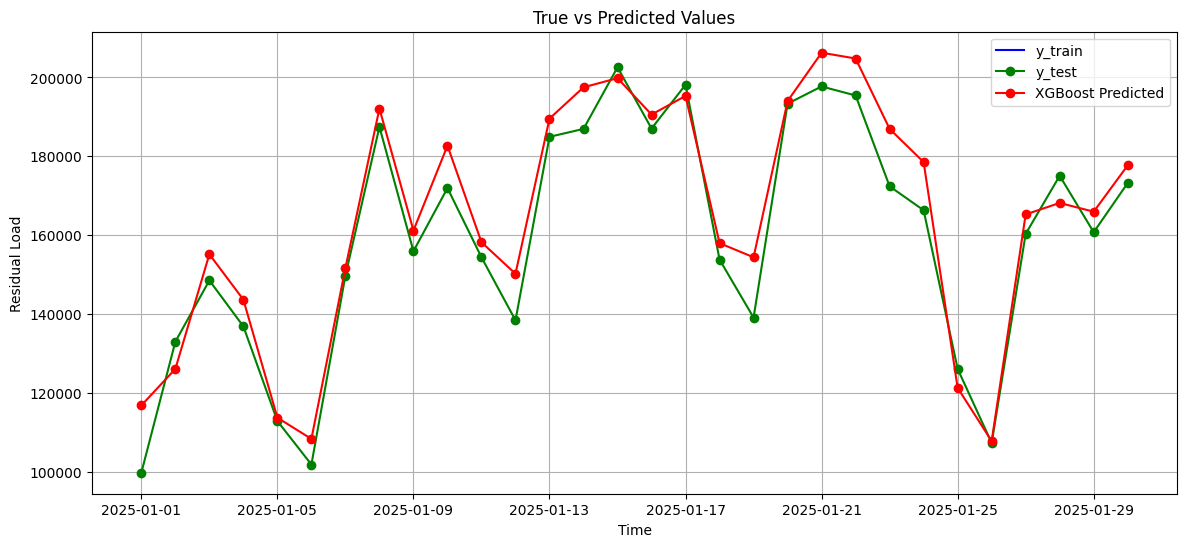

In [ ]:
start_date = '2025-01-01'
end_date = '2025-01-30'

y_train_df = pd.DataFrame(y_train).rename(columns={y_train.name: 'y_train'})
y_test_df = pd.DataFrame(y_test).rename(columns={y_test.name: 'y_test'})
xgb_pred_df = pd.DataFrame(xgb_pred, index=y_test.index).rename(columns={0: 'xgb_pred'})

# Merge them all into a single DataFrame
combined_df = pd.concat([y_train_df, y_test_df, xgb_pred_df], axis=1)
filtered_df = combined_df.loc[start_date:end_date]

# Plotting the combined DataFrame
plt.figure(figsize=(14, 6))

plt.plot(filtered_df.index, filtered_df['y_train'], label='y_train', color='blue')
plt.plot(filtered_df.index, filtered_df['y_test'], label='y_test', color='green', marker='o')
plt.plot(filtered_df.index, filtered_df['xgb_pred'], label='XGBoost Predicted', color='red', marker="o")


plt.title('True vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Residual Load')
plt.grid(True)
plt.legend()

plt.show()

### Feature Importance

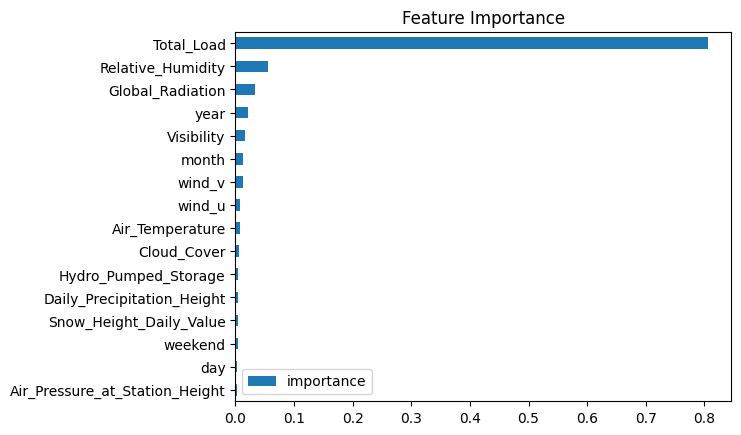

In [337]:
fi = pd.DataFrame(data=xgb_model.feature_importances_, index=xgb_model.feature_names_in_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### TODO
1. Timeseries Cross Validation

2. Lag Feature Optimization

3. Fine Tuning of XGBoost's Parameter and Hyperparameter

4. Rethink the splitting of dataset into train-val-test


Sources: https://www.youtube.com/watch?v=z3ZnOW-S550